In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

### The Big Problem

Suppose you want to monitor events occurring on the seafloor. Examples include detecting volcanic activity, identifying pipeline failures, or monitoring undersea communication cables. Doing so requires deploying instruments on the seafloor that can detect events and report them back to the surface. This setting imposes several key constraints and objectives:

1. **Latency.** Detections should be reported to the surface as quickly as possible.

2. **Utility maximization.** Overall utility is defined as  
   $$
   U = u_d \times (\text{number of correct detections}) - u_e \times (\text{energy consumed}),
   $$
   where:
   - Each sensor has a limited battery and must be replaced when depleted, imposing a cost per unit of energy used.
   - Passive sensing is effectively free, but communication consumes energy proportional to the number of transmitted bytes, at a rate of $e_b$ energy per byte.

3. **Surface access.** Only one or two sensors can be connected to the surface via a high-bandwidth but costly cable.

4. **Communication range.** There is a maximum reliable wireless communication distance $d$ between sensors.

5. **Signal attenuation.** Event signal strength decays with distance.

6. **Event model.** Each event occurs once, at a single unknown location.

7. **Local knowledge.** Each sensor knows its own location.

Under these constraints, the problem is to design a network of sensors and a set of communication protocols that reliably detect events and report them to the surface, while maximizing utility.

### Signal propogation

Let the distance from the event to some sensor be $d$ and the speed of sound be $\lambda$. Let $n(t)$ be the background noise for the sensor at time $t$. Say the event occurs at $t_0$. The sensor will get:

$$ s = s(d) h(t - t_0 - \frac{d}{\lambda}) + n(t) $$

Where $h$ is the waveform of the event. For instance:

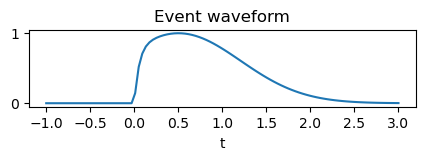

In [2]:
def h(t):
    return (t>0) * np.exp(-(t-0.5)**2) * (1 - np.exp(-20*t))

t = np.linspace(-1,3,100)
plt.figure(figsize=(5,1))
plt.plot(t,h(t))
plt.xlabel("t")
plt.title("Event waveform")
plt.show()

And $s(d)$ is the decay in signal strength with distance. Physicists look at this, but I'll just use a basic daying function e.g.,

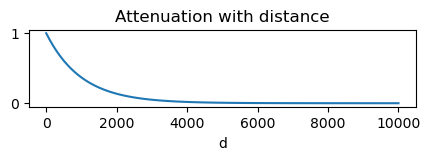

In [3]:
def s(d):
    return np.exp(-d*0.001)

d = np.linspace(0,10000,100)
plt.figure(figsize=(5,1))
plt.plot(d,s(d))
plt.xlabel("d")
plt.title("Attenuation with distance")
plt.show()

At a distance of 4 km the signal is mostly gone.

For the noise we can use a per-sensor Ornstein–Uhlenbeck process, which is more realistic than random noise.

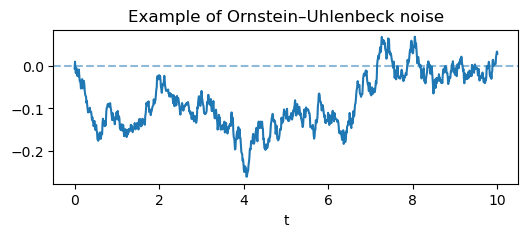

In [4]:
def ou_process(dt, steps):
    x = 0
    results = []
    for i in range(steps):
        x = x - 0.5 * x * dt + 0.1 * np.sqrt(dt) * np.random.normal()
        results.append(x)
    return np.array(results)

plt.figure(figsize=(6,2))
plt.plot(np.linspace(0,10,1000),ou_process(0.01,1000))
plt.axhline(0, linestyle="--", alpha=0.5)
plt.xlabel("t")
plt.title("Example of Ornstein–Uhlenbeck noise")
plt.show()

Putting these together we can get a model of the signal with the event occuring:

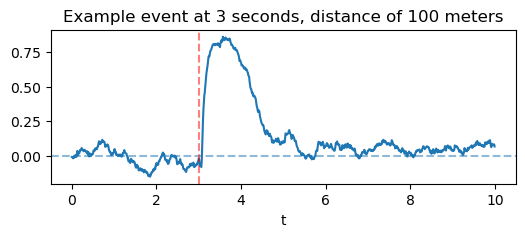

In [5]:
speed_of_sound = 1500

def sensor_signal(dt, steps, event_time, event_pos, sensor_pos):
    distance = np.linalg.norm(sensor_pos - event_pos)
    delay = distance / speed_of_sound
    background = ou_process(dt, steps)
    attenuated_strength = s(distance)
    t = np.arange(steps) * dt
    event_signal = h(t - event_time - delay)
    return attenuated_strength * event_signal + background

example = sensor_signal(0.01, 1000, 3, np.zeros(2), np.array([0,100])) # 100 meters away
t = np.arange(1000)*0.01
plt.figure(figsize=(6,2))
plt.plot(t, example)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.axvline(3, linestyle="--", alpha=0.5, color="red")
plt.xlabel("t")
plt.title("Example event at 3 seconds, distance of 100 meters")
plt.show()

And finally we can make a collection of sensors to do this:

In [6]:
def make_sensor_grid(rows, cols, spacing):
    xs = np.arange(cols) * spacing
    ys = np.arange(rows) * spacing
    xs = xs - xs.mean()
    ys = ys - ys.mean()
    X, Y = np.meshgrid(xs, ys)
    sensors = np.column_stack([X.ravel(), Y.ravel()])
    return sensors

def all_sensor_signals(dt, steps, event_time, event_pos, sensors):
    signals = [sensor_signal(dt, steps, event_time, event_pos, sensor_pos) for sensor_pos in sensors]
    return np.array(signals)

def visualize_array_and_signals(sensors, event_pos, signals, dt):
    num_sensors, steps = signals.shape
    t = np.arange(steps) * dt
    fig, (ax_space, ax_time) = plt.subplots(
        1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2]}
    )
    
    ax_space.scatter(
        event_pos[0], event_pos[1],
        color="black", s=80, marker="*", label="Event"
    )
    ax_space.set_aspect("equal")
    ax_space.set_xlabel("x (m)")
    ax_space.set_ylabel("y (m)")
    ax_space.legend()
    ax_space.set_title("Sensor layout")

    for i in range(num_sensors):
        ax_space.scatter([sensors[i][0]], [sensors[i][1]])
        ax_time.plot(t, signals[i], alpha=0.7)

    ax_time.axhline(0, linestyle="--", color="gray", alpha=0.5)
    ax_time.set_xlabel("t (s)")
    ax_time.set_title("Received signals")

    plt.tight_layout()
    plt.show()

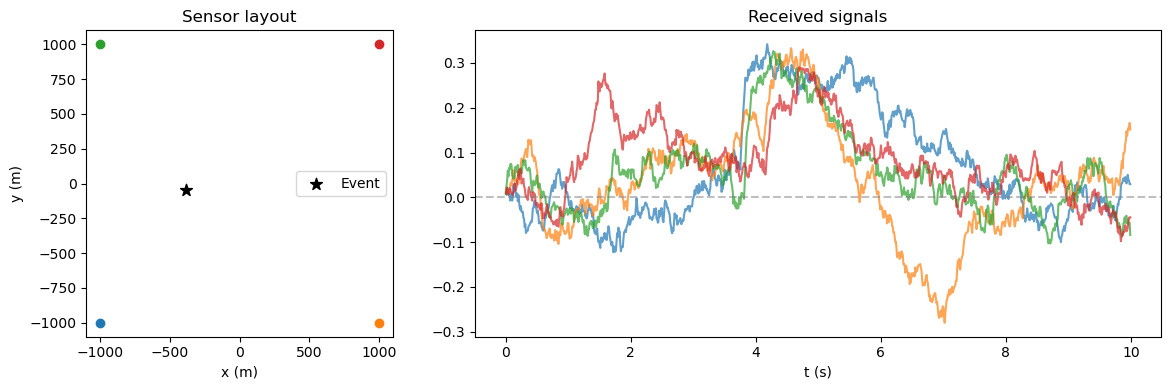

In [7]:
dt = 0.01
steps = 1000
t = np.arange(steps)*dt
sensors = make_sensor_grid(rows=2, cols=2, spacing=2000)
event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
event_time = 3
signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
visualize_array_and_signals(sensors, event_pos, signals, dt)

Fantastic, now we can simulate a bunch of nodes receiving a signal. But we still need to figure out how to do inference by combining information.

### Inference with no communication cost

Assuming we know the waveform of the event we are searching for, $h$, we can measure the correlation with the received signal:

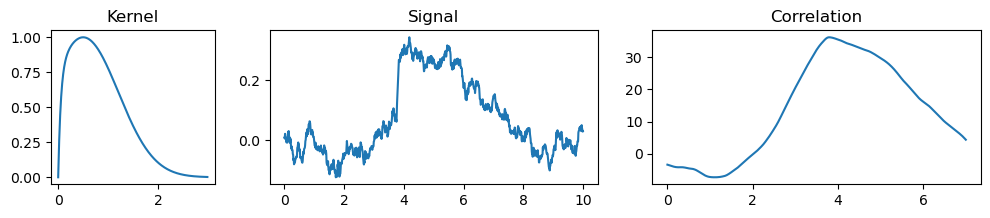

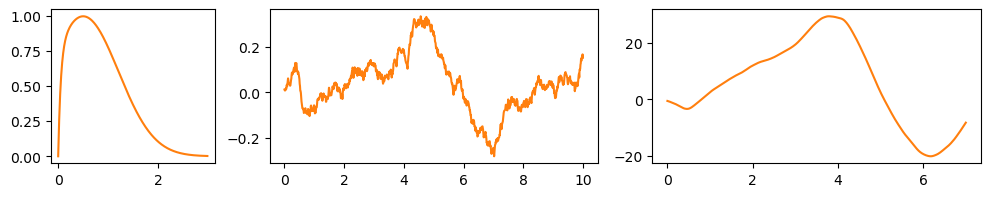

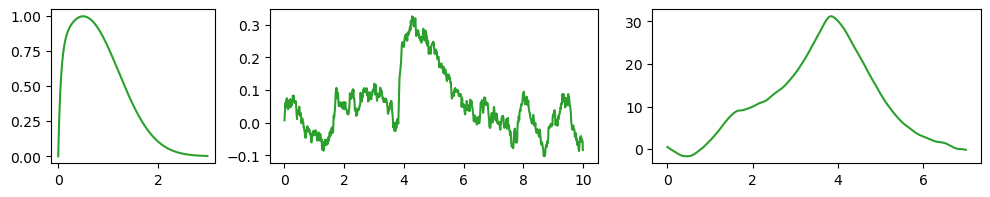

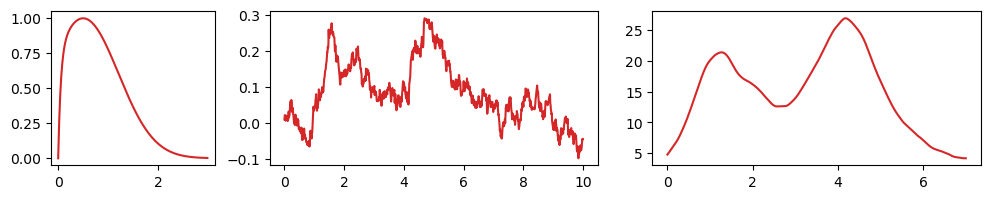

In [8]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
h_array = h(t)[:300]
for i in range(len(signals)):
    color = next(colors)
    conv = np.convolve(signals[i], h_array[::-1], mode="valid") # reverse because correlation is convolution with reversed kernel
    fig, (ax_h, ax_true, ax_conv) = plt.subplots(
        1, 3, figsize=(12, 2),
        gridspec_kw={"width_ratios": [1, 2, 2]}
    )
    ax_h.plot(np.arange(300)*dt, h_array, color=color)
    ax_true.plot(t,signals[i], color=color)
    ax_conv.plot(t[:len(conv)],conv, color=color)
    if i==0:
        ax_h.set_title("Kernel")
        ax_true.set_title("Signal")
        ax_conv.set_title("Correlation")

plt.show()

Now what we want to do is take these correlations and match them up will possible event positions (x,y). At the true event position the correlations should all line up and hence produce a strong sum:

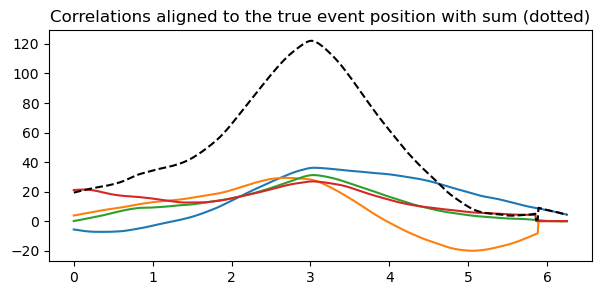

In [9]:
def shift_with_delay(sensors, signals, event_location, dt, speed_of_sound):
    aligned = []
    for i in range(len(sensors)):
        distance = np.linalg.norm(sensors[i] - event_location)
        delay = distance / speed_of_sound
        delay_in_steps = int(delay / dt)
        aligned.append(signals[i][delay_in_steps:])

    # pad and stack
    max_len = max(len(a) for a in aligned)
    out = np.full((len(sensors), max_len), 0, dtype=float)
    for i, a in enumerate(aligned):
        out[i, :len(a)] = a
    return out

correlations = [np.convolve(signals[i], h_array[::-1], mode="valid") for i in range(len(sensors))]

aligned_correlations = shift_with_delay(sensors, correlations, event_pos, dt, speed_of_sound)

plt.figure(figsize=(7,3))
for i in range(len(sensors)):
    plt.plot(np.arange(aligned_correlations.shape[1])*dt,aligned_correlations[i])
plt.plot(np.arange(aligned_correlations.shape[1])*dt,np.sum(aligned_correlations,axis=0), color="black", linestyle="--")
plt.title("Correlations aligned to the true event position with sum (dotted)")
plt.show()                    

We can then go through the different possible locations and see what the maximum value of the sum of these aligned curves is:

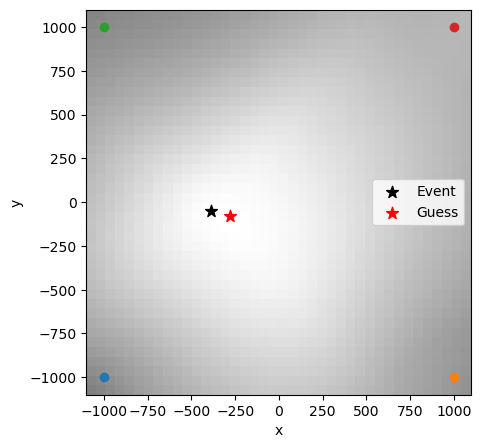

In [10]:
def get_score_grid(sensors, signals, dt, speed_of_sound):
    correlations = [np.convolve(signals[i], h_array[::-1], mode="valid") for i in range(len(sensors))]
    xs = np.linspace(np.min(sensors[:, 0]), np.max(sensors[:, 0]), 40)
    ys = np.linspace(np.min(sensors[:, 1]), np.max(sensors[:, 1]), 40)
    score_grid = np.zeros((len(xs), len(ys)))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            candidate_pos = np.array([x, y])
            aligned_correlations = shift_with_delay(sensors, correlations, candidate_pos, dt, speed_of_sound)
            score_grid[i, j] = np.max(np.sum(aligned_correlations, axis=0))
    return xs, ys, score_grid

def plot_score_grid(xs, ys, score_grid, sensors):
    flat_idx = np.argmax(score_grid)
    i_max, j_max = np.unravel_index(flat_idx, score_grid.shape)
    plt.figure(figsize=(6, 5))
    plt.imshow(score_grid.T, origin="lower", extent=[xs[0]-100, xs[-1]+100, ys[0]-100, ys[-1]+100], cmap="grey", alpha=0.5)
    for i in range(len(sensors)):
        plt.scatter([sensors[i][0]], [sensors[i][1]])
    plt.scatter(event_pos[0], event_pos[1], color="black", s=80, marker="*", label="Event")
    plt.scatter(xs[i_max], ys[j_max], color="red", s=80, marker="*", label="Guess")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
plot_score_grid(xs, ys, score_grid, sensors)

Great! Even with just 4 noisy signals we can guess the position roughly using the best alignment of the correlations. And with a few more, closer together, this should be even better. From scratch:

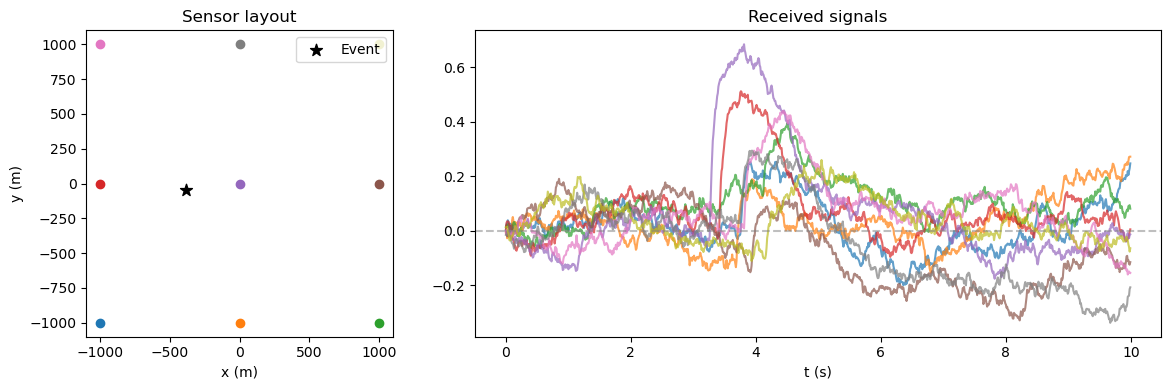

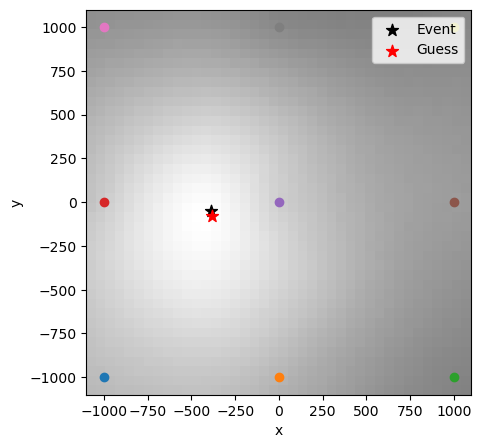

In [11]:
sensors = make_sensor_grid(rows=3, cols=3, spacing=1000)
signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
visualize_array_and_signals(sensors, event_pos, signals, dt)
xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
plot_score_grid(xs, ys, score_grid, sensors)

Neat! Now the only thing left to do is to determine whether an event has occured, which we will determine using the maximum value from the alignment. This is fairly straightforward, we just need to collect some labelled examples.

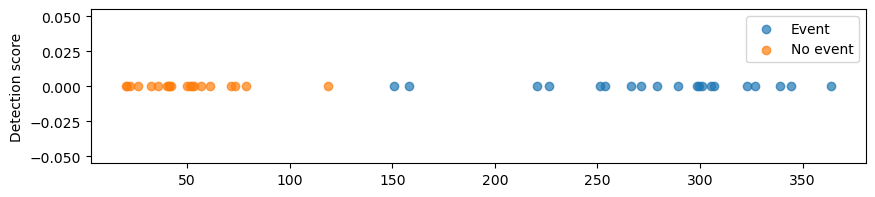

In [12]:
dt = 0.01
steps = 1000
t = np.arange(steps)*dt
sensors = make_sensor_grid(rows=3, cols=3, spacing=1000)

event_scores = []
for sample in range(20):
    event_time = np.random.rand()*t[-len(h_array)] # assume that there is len(h_array) at least at the end for correlaitons.
    event_pos = np.random.uniform(sensors.min(axis=0), sensors.max(axis=0))
    signals = all_sensor_signals(dt, steps, event_time, event_pos, sensors)
    xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
    event_scores.append(np.max(score_grid))

no_event_scores = []
for sample in range(20):
    signals = [ou_process(dt, steps) for i in range(len(sensors))]
    xs, ys, score_grid = get_score_grid(sensors, signals, dt, speed_of_sound)
    no_event_scores.append(np.max(score_grid))

plt.figure(figsize=(10, 2))
plt.scatter(event_scores, np.zeros(len(event_scores)), alpha=0.7, label="Event")
plt.scatter(no_event_scores, np.zeros(len(event_scores)), alpha=0.7, label="No event")

plt.ylabel("Detection score")
plt.legend()
plt.show()


Perfect! Using a threshold of around 120 will give us close to 100% accuracy. We could of course also try spacing the units further apart and using more complicated models too. But this is a nice start.

However, it's very communication-heavy. At minimum every sensor needs to send it's entire convolved data back to some central node in order to compute the alignment scores. This constant sending of information takes energy, which then imposes the cost mentioned at the very start, $u_e$.

### Inference with communication costs

One option is to just let each node perform an inference locally about whether something noteable has happened. Then all nodes need to send eachother is a message saying that they were triggered. Then we need to think about how to aggregate that to come up with an overall prediction. One option is to just set a threshold and say if anything meets that threshold the whole network will be triggered. We can test this fairly simply, we just track the maximum value each node gets at the convolution stage: